# Volume scan from  multiple sweeps using xradar
This example shows how to create a volume scan from multiple sweep files stored on AWS. The volume scan structure is based on [tree-like](https://xarray-datatree.readthedocs.io/en/latest/generated/datatree.DataTree.html) hierarchical collection of xarray objects 

## Imports

In [30]:
import fsspec
import xradar as xd
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
from pandas import to_datetime
from datetime import datetime
from functools import reduce
from matplotlib import pyplot
from datatree import DataTree, open_datatree
from matplotlib.animation import FuncAnimation
from xmovie import Movie
from IPython.display import HTML

from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
warnings.simplefilter("ignore")

In [6]:
cluster = SLURMCluster(queue="seseml",
                       memory='50GB',
                       cores=40,
                       processes=40,
                       walltime='24:00:00', 
#                        scheduler_options={
#                            'host': '172.22.179.3:7224', 
#                            'dashboard_address': ':7798'
#                        }
                      )

cluster.scale(jobs=1)
cluster

Dashboard: /proxy/40611/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.101:33467,Workers: 0
Dashboard: /proxy/40611/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/40611/status,
Dashboard: /proxy/40611/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.101:33467,Workers: 0
Dashboard: /proxy/40611/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [8]:
%%bash
squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1697738    seseml interact alfonso8  R       2:41      1 keeling-j01
           1697740    seseml dask-wor alfonso8  R       0:00      1 keeling-j03
           1697739    seseml dask-wor alfonso8  R       0:51      1 keeling-j02


## Access radar data from the Colombian radar network on AWS
Access data from the IDEAM bucket on AWS. Detailed information can be found [here](https://openradar-docs--102.org.readthedocs.build/projects/xradar/en/102/notebooks/Read-plot-Sigmet-data-from-AWS.html) 

In [9]:
def create_query(date, radar_site):
    """
    Creates a string for quering the IDEAM radar files stored in AWS bucket
    :param date: date to be queried. e.g datetime(2021, 10, 3, 12). Datetime python object
    :param radar_site: radar site e.g. Guaviare
    :return: string with a IDEAM radar bucket format
    """
    if (date.hour != 0) and (date.hour != 0):
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d%H}'
    elif (date.hour != 0) and (date.hour == 0):
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'
    else:
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'

Using `create_query` function we can list all files within the AWS bucket for a selected time-date.

In [6]:
date_query = datetime(2023, 4, 7)
radar_name = "Barrancabermeja" 
query = create_query(date=date_query, radar_site=radar_name)
str_bucket = 's3://s3-radaresideam/'
fs = fsspec.filesystem("s3", anon=True)
radar_files = sorted(fs.glob(f"{str_bucket}{query}*"))
len(radar_files)

1146

## Let's check the elevation at each file using `xradar.datatree` module

IDEAM radar network operates with a volume scan every five minutes. Each volume scan has four different tasks 
* *SURVP* "super-resolution" sweep at the lowest elevation angle, usually 0.5 deg,  with 720 degrees in azimuth (every 0.5 deg)
* *PRECA* task with 1.5, 2.4, 3.0, and 5.0 elevation angles and shorter range than *SURVP*
* *PRECB* task with 6.4 and 8.0 elevation angles and a shorter range than the previous task
* *PRECC* task with 10.0, 12.5, and 15.0 with a shorter range than all the previous tasks.

In [7]:
# List of first four task files
task_files = [fsspec.open_local(f'simplecache::s3://{i}', s3={'anon': True}, filecache={'cache_storage': '.'}) 
             for i in radar_files[:4]]
# list of xradar datatrees
ls_dt = [xd.io.open_iris_datatree(i).xradar.georeference() for i in task_files]

# sweeps and elevations within each task
for i in ls_dt:
    sweeps = list(i.children.keys())
    print(f"task sweeps: {sweeps}")
    for j in sweeps:
        print(f"{j}: {i[j].sweep_fixed_angle.values: .1f} [deg], {i[j].range.values[-1] / 1e3:.1f} [km]")
    print("----------------------------------------------------------------")

task sweeps: ['sweep_0']
sweep_0:  1.3 [deg], 298.9 [km]
----------------------------------------------------------------
task sweeps: ['sweep_0', 'sweep_1', 'sweep_2', 'sweep_3']
sweep_0:  1.5 [deg], 224.8 [km]
sweep_1:  2.4 [deg], 224.8 [km]
sweep_2:  3.1 [deg], 224.8 [km]
sweep_3:  5.1 [deg], 224.8 [km]
----------------------------------------------------------------
task sweeps: ['sweep_0', 'sweep_1']
sweep_0:  6.4 [deg], 175.0 [km]
sweep_1:  8.0 [deg], 175.0 [km]
----------------------------------------------------------------
task sweeps: ['sweep_0', 'sweep_1', 'sweep_2']
sweep_0:  10.0 [deg], 99.0 [km]
sweep_1:  12.5 [deg], 99.0 [km]
sweep_2:  15.0 [deg], 99.0 [km]
----------------------------------------------------------------


## Tree-like hierarchical object
Now we can create a tree-like hierarchical were each children corresponds to each taks within the same volume coverage pattern (VCP)

In [15]:
def create_query(date, radar_site):
    """
    Creates a string for quering the IDEAM radar files stored in AWS bucket
    :param date: date to be queried. e.g datetime(2021, 10, 3, 12). Datetime python object
    :param radar_site: radar site e.g. Guaviare
    :return: string with a IDEAM radar bucket format
    """
    if (date.hour != 0) and (date.hour != 0):
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d%H}'
    elif (date.hour != 0) and (date.hour == 0):
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'
    else:
        return f'l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}'


def data_accessor(file):
    """
    Open AWS S3 file(s), which can be resolved locally by file caching
    """
    return fsspec.open_local(f'simplecache::s3://{file}', s3={'anon': True}, filecache={'cache_storage': '/tmp/radar/'})


def create_path(dt):
    el = np.array([i for i in list(dt.children)])
    dt = pd.to_datetime(dt[f'{el[0]}'].time.values[0])
    return f"{dt:%Y%m%d%H%M}", dt


def fix_angle(ds, tol=None):
    angle_dict = xd.util.extract_angle_parameters(ds)
    # display(angle_dict)
    start_ang = angle_dict["start_angle"]
    stop_ang = angle_dict["stop_angle"]
    angle_res = angle_dict["angle_res"]
    direction = angle_dict["direction"]
    tol = angle_res / 1.75
    # first find exact duplicates and remove
    ds = xd.util.remove_duplicate_rays(ds)

    # second reindex according to retrieved parameters
    ds = xd.util.reindex_angle(
        ds, start_ang, stop_ang, angle_res, direction, method="nearest", 
        tolerance=tol
    )
    return ds



def new_structure(files):
    # radar_name = files[0].split('/')[-1].split('.')[0][:3]
    # elev = np.array(get_pars_from_ini('radar')[radar_name]['elevations'])
    # swps = {j: f"sweep_{idx}" for idx, j in enumerate(elev)}
    swps = {1.3: 'sweep_0', 1.5: 'sweep_1', 2.4: 'sweep_2', 3.1: 'sweep_3', 5.1: 'sweep_4', 
            6.4: 'sweep_5', 8.0: 'sweep_6', 10.0: 'sweep_7', 12.5: 'sweep_8', 15.0: 'sweep_9'}
    data = {}
    for i in files:
        dt = xd.io.open_iris_datatree(data_accessor(i))
        data.update({float(dt[j].sweep_fixed_angle.values): fix_angle(dt[j]).ds.xradar.georeference()
                     for j in list(dt.children)})
    return DataTree.from_dict({swps[k]: data[k] for k in list(data.keys())})


def concat_dt(dt, times):
    dates = list(dt.keys())
    swps = list(dt[dates[0]].children)
    new_dt = {}
    for i in swps:
        ds = xr.concat([dt[j][i].ds for j in dates], dim='times')
        ds = ds.assign_coords(times=("times", times))
        new_dt.update({i: ds})
    return new_dt


def radar_dt(radar_files):
    paths = []
    ls_time = []
    dt_dict = {}
    for idx, i in enumerate(radar_files):
        if idx % 4 == 0:
            ls_files = radar_files[idx: idx + 4]
            vcp = new_structure(ls_files)
            path, time = create_path(vcp)
            paths.append(path)
            ls_time.append(time)
            dt_dict[f"{path}"] = vcp
    ds = concat_dt(dt_dict, ls_time)
    root_ds = xr.Dataset(
        {
            "vcp_time": xr.DataArray(
                paths,
                dims=["time"],
                coords={"time": pd.Series(list(ls_time)).sort_values()},
            ),
        },
        coords={
            "time": pd.Series(list(ls_time)).sort_values(),
        },
    )
    root_ds = root_ds.sortby("time")
    ds["/"] = root_ds
    return DataTree.from_dict(ds)

In [16]:
# let's test it using the first 24 files in the bucket. We can include more files for visualization. e.g. radar_files[:96]
vcps_dt = radar_dt(radar_files[:288])

This is the tree-like object structure with timestamps at each vcp and its corresponding tasks and sweeps.

In [17]:
vcps_dt.to_zarr('test.zarr')

Now we have 6 vcps in one tree-like hierarchical object.

In [19]:
display(vcps_dt)

DataTree('None', parent=None)
│   Dimensions:   (time: 72)
│   Coordinates:
│     * time      (time) datetime64[ns] 2023-04-07T00:00:25.776000 ... 2023-04-07...
│   Data variables:
│       vcp_time  (time) <U12 '202304070000' '202304070005' ... '202304070555'
├── DataTree('sweep_0')
│       Dimensions:            (azimuth: 720, range: 994, times: 72)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.25 0.75 1.25 ... 358.8 359.2 359.8
│         * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
│           elevation          (times, azimuth) float64 1.318 1.318 ... 1.318 1.318
│           time               (times, azimuth) datetime64[ns] 2023-04-07T00:00:25.77...
│           longitude          float64 -73.76
│           latitude           float64 6.933
│           altitude           float64 105.0
│           spatial_ref        int64 0
│           x                  (times, azimuth, range) float64 4.362 ... -1.302e+03
│           y                  (times, azimuth, range) float64 999.7 ... 2.985e+05
│           z                  (times, azimuth, range) float64 128.1 135.0 ... 1.223e+04
│         * times              (times) datetime64[ns] 2023-04-07T00:00:25.776000 ... ...
│       Data variables: (12/17)
│           DBTH               (times, azimuth, range) float64 13.5 26.0 ... -32.0 -32.0
│           DBZH               (times, azimuth, range) float64 -32.0 -32.0 ... -32.0
│           VRADH              (times, azimuth, range) float64 0.0 2.046 ... 0.0 0.0
│           WRADH              (times, azimuth, range) float64 0.0 1.119 ... 0.0 0.0
│           ZDR                (times, azimuth, range) float64 -2.0 2.438 ... -8.0 -8.0
│           KDP                (times, azimuth, range) float64 0.04458 0.04458 ... -0.0
│           ...                 ...
│           DB_DBZE8           (times, azimuth, range) int16 0 0 0 0 0 0 ... 0 0 0 0 0 0
│           sweep_mode         (times) <U20 'azimuth_surveillance' ... 'azimuth_surve...
│           sweep_number       (times) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
│           prt_mode           (times) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
│           follow_mode        (times) <U7 'not_set' 'not_set' ... 'not_set' 'not_set'
│           sweep_fixed_angle  (times) float64 1.3 1.3 1.3 1.3 1.3 ... 1.3 1.3 1.3 1.3
├── DataTree('sweep_1')
│       Dimensions:            (azimuth: 360, range: 747, times: 72)
│       Coordinates:
│         * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│         * range              (range) float32 1e+03 1.3e+03 ... 2.245e+05 2.248e+05
│           elevation          (times, azimuth) float64 1.45 1.45 1.45 ... 1.45 1.45
│           time               (times, azimuth) datetime64[ns] 2023-04-07T00:01:14.46...
│           longitude          float64 -73.76
│           latitude           float64 6.933
│           altitude           float64 105.0
│           spatial_ref        int64 0
│           x                  (times, azimuth, range) float64 8.724 ... -1.959e+03
│           y                  (times, azimuth, range) float64 999.6 ... 2.245e+05
│           z                  (times, azimuth, range) float64 130.4 138.0 ... 8.761e+03
│         * times              (times) datetime64[ns] 2023-04-07T00:00:25.776000 ... ...
│       Data variables: (12/17)
│           DBTH               (times, azimuth, range) float64 6.5 27.0 ... -32.0 -32.0
│           DBZH               (times, azimuth, range) float64 -32.0 -32.0 ... -32.0
│           VRADH              (times, azimuth, range) float64 0.0 0.1395 ... 0.0 0.0
│           WRADH              (times, azimuth, range) float64 0.0 1.211 ... 0.0 0.0
│           ZDR                (times, azimuth, range) float64 -0.625 3.625 ... -8.0
│           KDP                (times, azimuth, range) float64 0.04458 0.04458 ... -0.0
│           ...                 ...
│           DB_DBZE8           (times, azimuth, range) float64 0.0 0.0 0.0 ... 0.

In [21]:
print(f"Size of data in tree = {vcps_dt.nbytes / 1e9 :.2f} GB")

Size of data in tree = 22.38 GB


In [22]:
del vcps_dt

### PPI animation using the lowest elevation angle

We can create an animation using the `FuncAnimation` module from `matplotlib` package

In [ ]:
# fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
# proj_crs = xd.georeference.get_crs(vcps_dt[times[0]]['1.3'])
# cart_crs = ccrs.Projection(proj_crs)
# sc = vcps_dt[times[0]]['1.3'].DBZH.plot.pcolormesh(x="x", y="y", vmin=-10, 
#                                                       vmax=50, cmap="Spectral_r", 
#                                                       edgecolors="face", 
#                                                       transform=cart_crs,
#                                                       ax=ax)

# title = f"Barranca radar - {vcps_dt[times[0]]['1.3'].sweep_fixed_angle.values: .1f} [deg] \n {pd.to_datetime(vcps_dt[times[0]]['1.3'].time.values[0]):%Y-%m-%d %H:%M}UTC"
# ax.set_title(title)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
#                   linewidth=1, color="gray", alpha=0.3, linestyle="--")
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# gl.top_labels = False
# gl.right_labels = False
# ax.coastlines()

# def update_plot(t):
#     sc.set_array(vcps_dt[t]['1.3'].DBZH.values.ravel())
#     ax.set_title(f"Barranca radar - {vcps_dt[t]['1.3'].sweep_fixed_angle.values: .1f} [deg] \n {pd.to_datetime(vcps_dt[t]['1.3'].time.values[0]):%Y-%m-%d %H:%M}UTC")

# ani = FuncAnimation(fig, update_plot, frames=times,
#                     interval=150)
# plt.close()
# display(HTML(ani.to_html5_video()))

## Bonus: Analysis-ready data, cloud-optimized (ARCO) format 

Tree-like hierarchical data can be stored using ARCO format.

In [24]:
! ls 'test.zarr'

sweep_0  sweep_2  sweep_4  sweep_6  sweep_8  time
sweep_1  sweep_3  sweep_5  sweep_7  sweep_9  vcp_time


Read ARCO format data using `open_datatree`

In [18]:
%%time
zarr_store = 'test.zarr'
dt = open_datatree(zarr_store, engine="zarr")

CPU times: user 118 ms, sys: 8.3 ms, total: 126 ms
Wall time: 125 ms


In [19]:
dt

DataTree('None', parent=None)
│   Dimensions:   (time: 72)
│   Coordinates:
│     * time      (time) datetime64[ns] 2023-04-07T00:00:25.776000 ... 2023-04-07...
│   Data variables:
│       vcp_time  (time) <U12 ...
├── DataTree('sweep_0')
│       Dimensions:            (times: 72, azimuth: 720, range: 994)
│       Coordinates:
│           altitude           float64 ...
│         * azimuth            (azimuth) float64 0.25 0.75 1.25 ... 358.8 359.2 359.8
│           latitude           float64 ...
│           longitude          float64 ...
│         * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
│           spatial_ref        int64 ...
│         * times              (times) datetime64[ns] 2023-04-07T00:00:25.776000 ... ...
│           x                  (times, azimuth, range) float64 ...
│           y                  (times, azimuth, range) float64 ...
│           z                  (times, azimuth, range) float64 ...
│       Data variables: (12/19)
│           DBTH               (times, azimuth, range) float32 ...
│           DBZH               (times, azimuth, range) float32 ...
│           DB_DBTE8           (times, azimuth, range) int16 ...
│           DB_DBZE8           (times, azimuth, range) int16 ...
│           DB_HCLASS          (times, azimuth, range) int16 ...
│           KDP                (times, azimuth, range) float32 ...
│           ...                 ...
│           follow_mode        (times) <U7 ...
│           prt_mode           (times) <U7 ...
│           sweep_fixed_angle  (times) float64 ...
│           sweep_mode         (times) <U20 ...
│           sweep_number       (times) int64 ...
│           time               (times, azimuth) datetime64[ns] ...
├── DataTree('sweep_1')
│       Dimensions:            (times: 72, azimuth: 360, range: 747)
│       Coordinates:
│           altitude           float64 ...
│         * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           latitude           float64 ...
│           longitude          float64 ...
│         * range              (range) float32 1e+03 1.3e+03 ... 2.245e+05 2.248e+05
│           spatial_ref        int64 ...
│         * times              (times) datetime64[ns] 2023-04-07T00:00:25.776000 ... ...
│           x                  (times, azimuth, range) float64 ...
│           y                  (times, azimuth, range) float64 ...
│           z                  (times, azimuth, range) float64 ...
│       Data variables: (12/19)
│           DBTH               (times, azimuth, range) float32 ...
│           DBZH               (times, azimuth, range) float32 ...
│           DB_DBTE8           (times, azimuth, range) int16 ...
│           DB_DBZE8           (times, azimuth, range) int16 ...
│           DB_HCLASS          (times, azimuth, range) int16 ...
│           KDP                (times, azimuth, range) float32 ...
│           ...                 ...
│           follow_mode        (times) <U7 ...
│           prt_mode           (times) <U7 ...
│           sweep_fixed_angle  (times) float64 ...
│           sweep_mode         (times) <U20 ...
│           sweep_number       (times) int64 ...
│           time               (times, azimuth) datetime64[ns] ...
├── DataTree('sweep_2')
│       Dimensions:            (times: 72, azimuth: 360, range: 747)
│       Coordinates:
│           altitude           float64 ...
│         * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
│           latitude           float64 ...
│           longitude          float64 ...
│         * range              (range) float32 1e+03 1.3e+03 ... 2.245e+05 2.248e+05
│           spatial_ref        int64 ...
│         * times              (times) datetime64[ns] 2023-04-07T00:00:25.776000 ... ...
│           x                  (times, azimuth, range) float64 ...
│           y                  (times, azimuth, range) float64 ...
│           z                  (times, azimuth, range) float64 ...
│ 

Now we can slicing data by time and elevation angle:

In [20]:
print(f"Size of data in tree = {dt.nbytes / 1e9 :.2f} GB")

Size of data in tree = 13.86 GB


In [21]:
%%time
ds_le = dt['sweep_0'].ds

CPU times: user 106 µs, sys: 45 µs, total: 151 µs
Wall time: 160 µs


In [22]:
ds_le

<xarray.DatasetView>
Dimensions:            (times: 72, azimuth: 720, range: 994)
Coordinates:
    altitude           float64 ...
  * azimuth            (azimuth) float64 0.25 0.75 1.25 ... 358.8 359.2 359.8
    latitude           float64 ...
    longitude          float64 ...
  * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
    spatial_ref        int64 ...
  * times              (times) datetime64[ns] 2023-04-07T00:00:25.776000 ... ...
    x                  (times, azimuth, range) float64 ...
    y                  (times, azimuth, range) float64 ...
    z                  (times, azimuth, range) float64 ...
Data variables: (12/19)
    DBTH               (times, azimuth, range) float32 ...
    DBZH               (times, azimuth, range) float32 ...
    DB_DBTE8           (times, azimuth, range) int16 ...
    DB_DBZE8           (times, azimuth, range) int16 ...
    DB_HCLASS          (times, azimuth, range) int16 ...
    KDP                (times, azimuth, range) float32 ...
    ...                 ...
    follow_mode        (times) <U7 ...
    prt_mode           (times) <U7 ...
    sweep_fixed_angle  (times) float64 ...
    sweep_mode         (times) <U20 ...
    sweep_number       (times) int64 ...
    time               (times, azimuth) datetime64[ns] ...

(-300000.0, 300000.0)

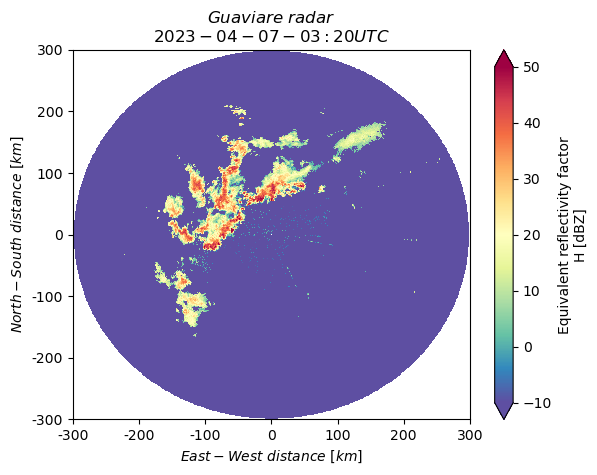

In [23]:
fig, ax = plt.subplots()
ds_le.sel(times='2023-04-07 03:20', method='nearest').DBZH.plot(x="x", y='y', vmin=-10, vmax=50, cmap="Spectral_r")
m2km = lambda x, _: f"{x/1000:g}"
# set new ticks
ax.xaxis.set_major_formatter(m2km)
ax.yaxis.set_major_formatter(m2km)
ax.set_ylabel("$North - South \ distance \ [km]$")
ax.set_xlabel("$East - West \ distance \ [km]$")
ax.set_title(
    f"$Guaviare \ radar$"
    + "\n"
    + f"${to_datetime(ds_le.sel(times='2023-04-07 03:20', method='nearest').times.values): %Y-%m-%d - %H:%M}$"
    + "$ UTC$"
)
ax.set_ylim(-300000, 300000)
ax.set_xlim(-300000, 300000)

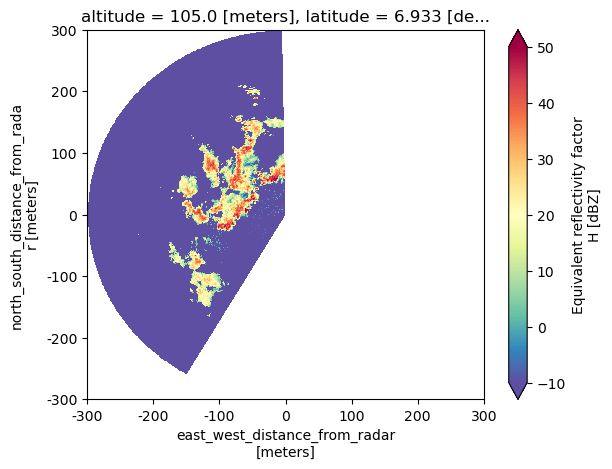

In [24]:
fig, ax = plt.subplots()
m2km = lambda x, _: f"{x/1000:g}"
# set new ticks
ax.xaxis.set_major_formatter(m2km)
ax.yaxis.set_major_formatter(m2km)
ax.set_ylabel("$North - South \ distance \ [km]$")
ax.set_xlabel("$East - West \ distance \ [km]$")
ax.set_title(
    f"$Guaviare \ radar$"
    + "\n"
    + f"${to_datetime(ds_le.sel(times='2023-04-07 03:20', method='nearest').times.values): %Y-%m-%d - %H:%M}$"
    + "$ UTC$"
)
ax.set_ylim(-300000, 300000)
ax.set_xlim(-300000, 300000)
ds_le.sel(times='2023-04-07 03:20', method='nearest').sel(azimuth=slice (210, 359,)).DBZH.plot(x='x', y='y', cmap='Spectral_r', vmin=-10, vmax=50, 
                                                                                              )

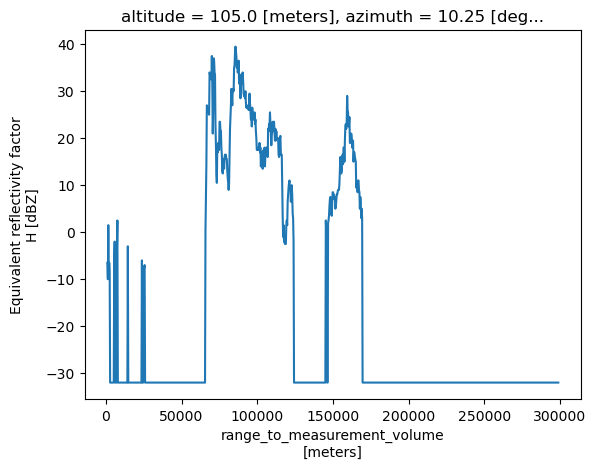

In [25]:
ds_le.sel(times='2023-04-07 03:20', method='nearest').sel(azimuth=10, method='nearest').DBZH.plot()

In [26]:
r_total = (0.0376 * ds_le.DBZH ** 0.6112 * 12).sum('times')

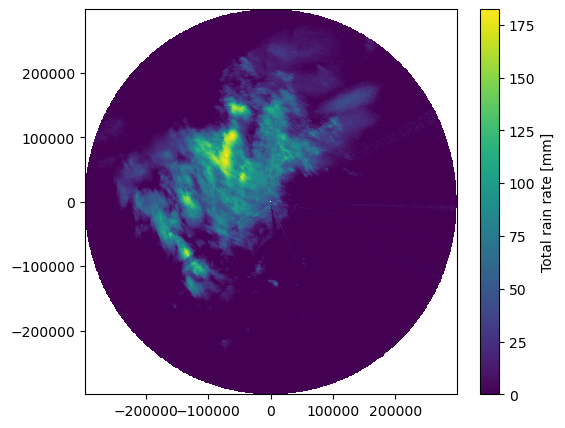

In [27]:
fig, ax = plt.subplots(figsize=(6,5))
p = ax.pcolormesh(ds_le.x.isel(times=0).values, ds_le.y.isel(times=0).values, r_total)
fig.colorbar(p, ax=ax, label='Total rain rate [mm]')

In [38]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
proj_crs = xd.georeference.get_crs(ds_le)
cart_crs = ccrs.Projection(proj_crs)
sc = ds_le.isel(times=0).DBZH.plot.pcolormesh(x="x", y="y", vmin=-10,
                                                      vmax=50, cmap="Spectral_r",
                                                      # edgecolors="face",
                                                      transform=cart_crs,
                                                      ax=ax)

title = f"Barranca radar - {ds_le.isel(times=0).sweep_fixed_angle.values: .1f} [deg] \n " \
        f"{pd.to_datetime(ds_le.isel(times=0).time.values[0]):%Y-%m-%d %H:%M}UTC"
ax.set_title(title)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color="gray", alpha=0.3, linestyle="--")
plt.gca().xaxis.set_major_locator(plt.NullLocator())
gl.top_labels = False
gl.right_labels = False
ax.coastlines()

def update_plot(t):
    sc.set_array(ds_le.sel(times=t).DBZH.values.ravel())
    ax.set_title(f"Barranca radar - {ds_le.sel(times=t).sweep_fixed_angle.values: .1f} [deg] \n "
                 f"{pd.to_datetime(ds_le.sel(times=t).time.values[0]):%Y-%m-%d %H:%M}UTC")

ani = FuncAnimation(fig, update_plot, frames=ds_le.times.values,
                    interval=100)
plt.close()
display(HTML(ani.to_html5_video()))

In [ ]:
ani.save(f'./results/ani.mp4')

In [49]:
mov = Movie(ds_le.DBZH.chunk(chunks={'times':1}), framedim='times')
mov.save('movie.mp4',  remove_movie=False, progress=True, overwrite_existing=True, parallel=True)

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x2afe747bba90>>
Traceback (most recent call last):
  File "/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/distributed/utils_perf.py", line 183, in _gc_callback
    self._fractional_timer.start_timing()
  File "/data/keeling/a/alfonso8/miniconda3/envs/xradar/lib/python3.9/site-packages/distributed/utils_perf.py", line 118, in start_timing
    assert self._cur_start is None
AssertionError: 

KeyboardInterrupt

